In [1]:
import torch
import torch.nn as nn

import time

import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
data_path = '../data/'
prefix = 'aug'
train_data = torch.load(data_path + prefix + '_data_large.pt')
train_label = torch.load(data_path + prefix + '_label_large.pt')

train_size = train_data.size(0)

In [3]:
data_path = '../data/'
prefix = 'test'
test_data = torch.load(data_path + prefix + '_data_large.pt')
test_label = torch.load(data_path + prefix + '_label_large.pt')

test_size = test_data.size(0)

In [4]:
train_data = train_data / 255
test_data = test_data / 255

In [5]:
# show size
print("Training data, ", train_data.size(), "Type", train_data.type())
print("Training label,", train_label.size())



Training data,  torch.Size([38500, 3, 128, 128]) Type torch.FloatTensor
Training label, torch.Size([38500])


In [6]:
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

torch.Size([38500, 3, 128, 128]) torch.Size([38500]) torch.Size([612, 3, 128, 128]) torch.Size([612])


In [7]:
train_data_size = train_data.size(0)
print(train_data_size)
print(train_data.is_contiguous())

38500
True


## Utility Functions
- display num param
- show image

- get error
- evaluate on test data

In [8]:
# Util func
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

In [9]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')


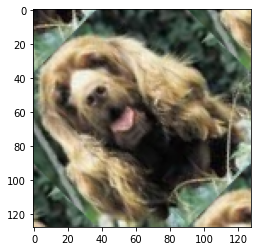

tensor(9)


In [10]:
show(train_data[78])
print(train_label[78])

In [11]:
def get_error( scores , labels ):
    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

In [12]:
def eval_on_test_set(model):

    test_size = test_data.size(0)
    running_error = 0
    num_batches = 0

    for i in range(0,(test_size//bs)*bs, bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        inputs = (minibatch_data - mean)/std

        scores = model(inputs) 

        error = get_error(scores, minibatch_label)

        running_error += error.item()

        num_batches += 1

    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 , 'percent')
    return total_error

## Build CNN
A VGG-liked CNN Structure

In [13]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 64 x 64 --> 64 x 32 x 32        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1)
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 32 x 32 --> 128 x 16 x 16
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 16 x 16 --> 256 x 8 x 8        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 8 x 8 --> 512 x 4 x 4
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 4 x 4 --> 512 x 2 x 2
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

        # dropout layer
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout(x)

        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)

        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        x = self.conv5a(x)
        x = torch.relu(x)
        x = self.pool5(x)
        x = self.dropout(x)

        x = x.contiguous()
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

A baseline EfficientNet architecture

In [14]:
import torchvision

class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.EfficientNetB4 = torchvision.models.efficientnet_b4(pretrained=True)
        self.EfficientNetB4 = self.EfficientNetB4.train()
        self.linear1 = nn.Linear(1000, 10)
    
    def forward(self, x):
        x = self.EfficientNetB4(x)
        x = nn.ReLU()(x)
        x = self.linear1(x)
        return x
        

#A larger VGG network

In [15]:
class VGG_convnet_large(nn.Module):

    def __init__(self):

        super(VGG_convnet_large, self).__init__()

        # block 1:         3 x 128 x 128 --> 64 x 64 x 64        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1)
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 64 x 64 --> 128 x 32 x 32
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 32 x 32 --> 256 x 16 x 16        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 16 x 16 --> 512 x 8 x 8
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 8 x 8 --> 512 x 4 x 4
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5  = nn.MaxPool2d(2,2)

        self.linear1 = nn.Linear(512*4*4, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

        # dropout layer
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)
        # x = self.dropout(x)

        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)
        # x = self.dropout(x)

        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        x = self.conv5a(x)
        x = torch.relu(x)
        x = self.pool5(x)
        # x = self.dropout(x)

        x = x.contiguous()
        x = x.view(-1, 512*4*4)
        x = self.linear1(x)
        x = torch.relu(x)
        # x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

#A ResNet-34 network

In [16]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      x += identity
      x = self.relu(x)
      return x
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [17]:
net = EfficientNet()
# net = VGG_convnet_large()
# net = ResNet152(num_classes=10)
print(net)
display_num_param(net)

EfficientNet(
  (EfficientNetB4): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [18]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [19]:
mean = train_data.mean()

In [20]:
std = train_data.std()

In [21]:
net = net.to(device)

mean = mean.to(device)

std = std.to(device)

In [22]:
mean, std

(tensor(0.4375, device='cuda:0'), tensor(0.2633, device='cuda:0'))

##Define Early Stopping function

In [23]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time test error improved.
            verbose (bool): If True, prints a message for each test error improvement. 
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.        
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.test_err_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, test_err, model):

        score = -test_err

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(test_err, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            self.trace_func(f'Current Best Accuracy: {1 + self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(test_err, model)
            self.counter = 0

    def save_checkpoint(self, test_err, model):
        if self.verbose:
            self.trace_func(f'Test error decreased ({self.test_err_min:.6f} --> {test_err:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.test_err_min = test_err

## Define Hyper-parameters

In [24]:
from cutmix.utils import CutMixCrossEntropyLoss

criterion = nn.CrossEntropyLoss()
# criterion = CutMixCrossEntropyLoss(True)
optimizer=torch.optim.AdamW(net.parameters(), lr=1e-4)
bs = 25
patience = 12
epochs = 100

In [25]:
train_data.shape

torch.Size([38500, 3, 128, 128])

In [26]:
train_label.shape

torch.Size([38500])

## Training

In [27]:
start=time.time()

early_stopping = EarlyStopping(patience=patience, verbose=True)

train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0
    running_error = 0
    num_batches = 0
    
    shuffled_indices=torch.randperm(train_data_size)
 
    for count in range(0, (train_data_size//bs)*bs, bs):
    
        optimizer.zero_grad()
         
        indices=shuffled_indices[count:count+bs]
        minibatch_data = train_data[indices]
        minibatch_label = train_label[indices]

        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std
        
        inputs.requires_grad_()

        scores = net(inputs) 

        loss = criterion(scores, minibatch_label) 
          
        loss.backward()

        optimizer.step()
    
        running_loss += loss.detach().item()
        
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    test_err = 0
    if epoch % 1 == 0:
        print('epoch=', epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 , 'percent')
        test_err = eval_on_test_set(net) 
        print(' ')
    
    
    early_stopping(test_err, net)
        
    if early_stopping.early_stop:
        print("Early stopping.....")
        break

# load the last checkpoint with the best model
net.load_state_dict(torch.load('checkpoint.pt'))

epoch= 0 	 time= 184.3190016746521 	 loss= 1.4345865591005846 	 error= 50.36623476774662 percent
test error  =  30.50000195701917 percent
 
Test error decreased (inf --> 0.305000). Saving model...
epoch= 1 	 time= 377.6109998226166 	 loss= 0.8122498706757248 	 error= 27.97402790227494 percent
test error  =  22.83333564798037 percent
 
Test error decreased (0.305000 --> 0.228333). Saving model...
epoch= 2 	 time= 568.967999458313 	 loss= 0.5822173761663498 	 error= 20.05454781380567 percent
test error  =  19.33333526055018 percent
 
Test error decreased (0.228333 --> 0.193333). Saving model...
epoch= 3 	 time= 763.3510015010834 	 loss= 0.42261728512776364 	 error= 14.506495947187597 percent
test error  =  20.333335548639297 percent
 
EarlyStopping counter: 1 out of 12
Current Best Accuracy: 0.8066666473944982
epoch= 4 	 time= 956.9500002861023 	 loss= 0.3140727882696824 	 error= 10.745457016028368 percent
test error  =  20.166668792565666 percent
 
EarlyStopping counter: 2 out of 12
Cur

<All keys matched successfully>

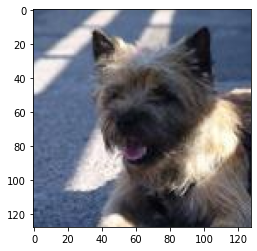

In [32]:
show(test_data[30])

#Show final result on test set

In [31]:
eval_on_test_set(net)

test error  =  17.333335926135383 percent


0.17333335926135382